(0.31672846125645726,
 0.6844919786096256,
 0.332500090615193,
 0.6844919786096256,
 0.39398907103825137,
 0.6219739758794726,
 0.6844919786096256)

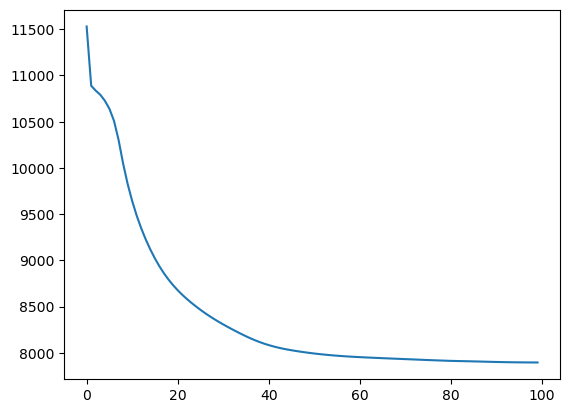

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.neighbors import kneighbors_graph
from sklearn.metrics.cluster import adjusted_rand_score as ARI
from sklearn.metrics.cluster import normalized_mutual_info_score as NMI

import warnings
warnings.filterwarnings('ignore')
from util import eval, loadDataset, normalization, kmeansInitialization

eps = torch.tensor(10 ** -10)

datasets = ['3Sources.npy',
'BBCSport.npy',
'Caltech101.npy',
'Caltech_2.npy',
'Citeseer.npy',
'Coil100.npy',
'Cora.npy',
'EYaleB10.npy',
'Handwritten.npy',
'MNIST10.npy',
'UCIdigit.npy',
'Umist.npy',
'Yale32.npy',
'Yeast.npy',
'Cora2.npy',
'texas.npy',
'wisconsin.npy',
'washington.npy',
'cornell.npy']


X0, Y, V, c = loadDataset(15)


r = 20
k = 5
alpha = 1000
lamda = 0.1
gamma = 0.0001
iter = 100

W = []
H = []
X = []

for v in range(V):
    
    # Normalizing Xs ???
    
    X.append(torch.tensor(X0[v]).type(torch.float32))
    
    d, n = X[v].shape
    
    W0 = torch.rand(d, r)
    H0 = torch.rand(r, n)
    
    W.append(W0)
    H.append(H0)

S = []
Wm = []
Wp = []
D = []
for v in range(V):
    
    
    S0 = torch.cdist(H[v].T, H[v].T)
    S0 = torch.exp(-(S0**2/(2 * lamda)))
    S.append(S0/torch.sum(S0, dim=1))
    
    Wm.append((S[v] + S[v].T)/2)

    Wp.append(torch.diag(torch.sum(Wm[v], dim = 1)))

    D.append(torch.eye(n))

# Optimization
err = torch.zeros(iter)

for t in range(iter):

    for v in range(V):
        
        D[v] = torch.diag(1/torch.maximum(2 * torch.norm(X[v]- W[v] @ H[v], dim=0), eps))
        
        # Updating Hs
        Q = torch.zeros(r, n)
        for v2 in range(V):
            Q += H[v2] 
        Q += H[v]
        
        Hn = W[v].T @ X[v]        @ D[v]             + gamma * (H[v] @ Wm[v])
        Hd = W[v].T @ W[v] @ H[v] @ D[v] + alpha * Q + gamma * (H[v] @ Wp[v])
        H[v] = H[v] * (Hn / torch.maximum(Hd, eps))
        
        # Updating Ws
        Wn = X[v]        @ D[v] @ H[v].T 
        Wd = W[v] @ H[v] @ D[v] @ H[v].T 
        W[v] = W[v] * (Wn / torch.maximum(Wd, eps))
        
        # Updating S
        S0 = torch.cdist(H[v].T, H[v].T)
        S0 = torch.exp(-(S0**2/(2 * lamda)))
        S.append(S0/torch.sum(S0, dim=1))

        Wm.append((S[v] + S[v].T)/2)

        Wp.append(torch.diag(torch.sum(Wm[v], dim = 1)))

        # Calculating cost function
        err[t] += torch.norm(X[v] - W[v] @ H[v]) ** 2 + gamma * torch.trace(H[v] @ (Wp[v] - Wm[v]) @ H[v].T) \
        + lamda * torch.sum(S[v] * torch.log(S[v]))
           
plt.plot(err)


Hsum = torch.zeros(r, n)
for v in range(V):
    Hsum += H[v]
    
Hfinal = Hsum / V

#normalization ???

pred = KMeans(n_clusters=c).fit(Hfinal.T).labels_

nmi, acc, ari, f1mi, f1ma, f1we, pur = eval(Y, pred)
nmi, acc, ari, f1mi, f1ma, f1we, pur